# Association between Fertility & Local Municipal Characteristics in Denmark 

## Imports

In [291]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

## Load the Data

Load the data extracts from DenmarkStatistik (process the data) and merge with geometries of municipalities in Denmark to a geo dataframe.

In [292]:
# total fertility rate (TFR)
data_fer = pd.read_excel('Data/fertility_rates_by_municipality_2021.xlsx')
# education
data_edu = pd.read_excel('Data/Education_women_master_2021.xlsx')
# disposable income
data_inc = pd.read_excel('Data/Disposable_income_2021.xlsx')
# dwelings with CPR
data_dwe = pd.read_excel('Data/Dwellings_with_CPR_2021.xlsx')
# household wealth
data_wea = pd.read_excel('Data/Household_wealth_2021.xlsx')

## Data processing 

### Fertility

In [293]:
# FERTILITY RATE
data_fer.head()

,Unnamed: 0,2021
0,Copenhagen,1 563.9
1,Frederiksberg,1 787.8
2,Dragør,2 510.9
3,Tårnby,2 056.7
4,Albertslund,1 608.7


In [294]:
# replacing missing values with 0
data_fer = data_fer.replace('..', 0)
# removing spaces and convert numbers to float
data_fer[2021] = data_fer[2021].str.replace(' ', '').astype(float)
# replacing non-finite values with 0
data_fer[2021] = data_fer[2021].replace([np.inf, -np.inf, np.nan], 0)

In [295]:
# the total fertility rate is per 1000 women, so lets change so its easier to understand and round it
data_fer[2021] = round(data_fer[2021] / 1000, 2)

In [296]:
# change the name of the columnns
data_fer.rename(columns = {'Unnamed: 0':'municipality_nm', 2021:'TFR'}, inplace = True)

In [297]:
data_fer.head()

,municipality_nm,TFR
0,Copenhagen,1.56
1,Frederiksberg,1.79
2,Dragør,2.51
3,Tårnby,2.06
4,Albertslund,1.61


### Education

In [298]:
data_edu.head()

,2021,I alt (15-19 år),15-19 år,I alt (20-24 år),20-24 år,I alt (25-29 år),25-29 år,I alt (30-34 år),30-34 år,I alt (35-39 år),35-39 år
0,København,13 267,0,37 149,552,46 656,14 161,35 547,16 102,23 775,9 644
1,Frederiksberg,2 306,0,5 164,74,5 697,2 092,4 442,2 307,3 334,1 594
2,Dragør,429,0,172,1,176,20,309,94,418,134
3,Tårnby,1 189,0,865,5,904,94,1 248,255,1 388,298
4,Albertslund,818,0,952,9,867,97,839,119,785,127


In [299]:
# deal with type (to float)
columns_to_process = data_edu.columns[1:]
for column in columns_to_process:
    data_edu[column] = data_edu[column].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)


In [300]:
# sum all 'I alt' and sum all age groups and then take the percentage i.e. how many women in perc (age 15-39) have master or above and round it
data_edu['Sum_alt']=data_edu.iloc[:,[1,3,5,7,9]].sum(axis=1)
data_edu['Sum_master']=data_edu.iloc[:,[2,4,6,8,10]].sum(axis=1)
data_edu['master_perc'] = round(data_edu['Sum_master'] * 100 / data_edu['Sum_alt'], 2)

In [301]:
data_edu.rename(columns = {2021:'municipality_nm'}, inplace = True)

In [302]:
data_edu.head()

,municipality_nm,I alt (15-19 år),15-19 år,I alt (20-24 år),20-24 år,I alt (25-29 år),25-29 år,I alt (30-34 år),30-34 år,I alt (35-39 år),35-39 år,Sum_alt,Sum_master,master_perc
0,København,13267.0,0,37149.0,552,46656.0,14161.0,35547.0,16102.0,23775.0,9644.0,156394.0,40459.0,25.87
1,Frederiksberg,2306.0,0,5164.0,74,5697.0,2092.0,4442.0,2307.0,3334.0,1594.0,20943.0,6067.0,28.97
2,Dragør,429.0,0,172.0,1,176.0,20.0,309.0,94.0,418.0,134.0,1504.0,249.0,16.56
3,Tårnby,1189.0,0,865.0,5,904.0,94.0,1248.0,255.0,1388.0,298.0,5594.0,652.0,11.66
4,Albertslund,818.0,0,952.0,9,867.0,97.0,839.0,119.0,785.0,127.0,4261.0,352.0,8.26


### disposable income


In [303]:
# disposable income (average for men and women)
data_inc

,Unnamed: 0,2021
0,København,263 154
1,Frederiksberg,319 321
2,Dragør,350 841
3,Tårnby,275 721
4,Albertslund,230 832
...,...,...
93,Morsø,229 968
94,Rebild,270 439
95,Thisted,241 755
96,Vesthimmerlands,244 219


In [304]:
data_inc[2021] = data_inc[2021].str.replace(' ', '').astype(float)

In [305]:
# rename
data_inc.rename(columns = {'Unnamed: 0':'municipality_nm', 2021:'disp_income_avg_k'}, inplace = True)

In [306]:
# show in thousands and round the number
data_inc['disp_income_avg_k'] = round(data_inc['disp_income_avg_k']/1000, 2)

In [307]:
data_inc.head()

,municipality_nm,disp_income_avg_k
0,København,263.15
1,Frederiksberg,319.32
2,Dragør,350.84
3,Tårnby,275.72
4,Albertslund,230.83


### Dwellings

In [308]:
data_dwe

,2021,- 50 kvm,50-74 kvm,75-99 kvm,100-124 kvm,125-149 kvm,150-174 kvm,175 kvm og derover,Uoplyst
0,København,34 050,120 748,84 785,41 034,18 102,7 823,6 859,405
1,Frederiksberg,4 254,16 871,16 592,8 050,3 939,1 974,2 075,28
2,Dragør,172,694,1 074,1 043,1 372,910,832,7
3,Tårnby,1 187,4 472,5 443,3 139,2 494,1 398,715,7
4,Albertslund,1 899,1 639,3 599,3 027,1 322,648,236,2
...,...,...,...,...,...,...,...,...,...
94,Morsø,254,1 415,1 570,1 643,1 683,1 323,2 060,4
95,Rebild,192,980,1 821,2 106,2 238,2 259,3 430,26
96,Thisted,459,2 298,3 601,3 286,3 307,3 015,4 543,3
97,Vesthimmerlands,454,1 756,2 999,2 904,3 024,2 479,3 731,8


In [309]:
# square meters of dwelling per household in each municipality, 
# but we are gonna make a new variable - perc. of people in the municipality with the dweling more than 74 square meters. The missing
# data will be removed (Uoplyst):
data_dwe.drop(['Uoplyst'], inplace = True, axis = 1)

In [310]:
# deal with type (to float)
columns_to_process = data_dwe.columns[1:]
for column in columns_to_process:
    data_dwe[column] = data_dwe[column].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)

In [311]:
# sum all 'I alt' and sum all age groups and then take the percentage i.e. how many women in perc (age 15-39) have master or above
data_dwe['Sum_total'] = data_dwe.iloc[:,1:].sum(axis=1)
data_dwe['Sum_more_than_74'] = data_dwe.iloc[:,3:7].sum(axis=1)
data_dwe['dwelling_above_74_perc'] = round(data_dwe['Sum_more_than_74'] * 100 / data_dwe['Sum_total'], 2)

In [312]:
# rename
data_dwe.rename(columns = {2021:'municipality_nm'}, inplace = True)

In [313]:
data_dwe

,municipality_nm,- 50 kvm,50-74 kvm,75-99 kvm,100-124 kvm,125-149 kvm,150-174 kvm,175 kvm og derover,Sum_total,Sum_more_than_74,dwelling_above_74_perc
0,København,34050.0,120748.0,84785.0,41034.0,18102.0,7823.0,6859.0,313401.0,151744.0,48.42
1,Frederiksberg,4254.0,16871.0,16592.0,8050.0,3939.0,1974.0,2075.0,53755.0,30555.0,56.84
2,Dragør,172.0,694.0,1074.0,1043.0,1372.0,910.0,832.0,6097.0,4399.0,72.15
3,Tårnby,1187.0,4472.0,5443.0,3139.0,2494.0,1398.0,715.0,18848.0,12474.0,66.18
4,Albertslund,1899.0,1639.0,3599.0,3027.0,1322.0,648.0,236.0,12370.0,8596.0,69.49
...,...,...,...,...,...,...,...,...,...,...,...
94,Morsø,254.0,1415.0,1570.0,1643.0,1683.0,1323.0,2060.0,9948.0,6219.0,62.52
95,Rebild,192.0,980.0,1821.0,2106.0,2238.0,2259.0,3430.0,13026.0,8424.0,64.67
96,Thisted,459.0,2298.0,3601.0,3286.0,3307.0,3015.0,4543.0,20509.0,13209.0,64.41
97,Vesthimmerlands,454.0,1756.0,2999.0,2904.0,3024.0,2479.0,3731.0,17347.0,11406.0,65.75


### wealth

In [314]:
data_wea

,Unnamed: 0,2021
0,København,3 629 877
1,Frederiksberg,4 487 733
2,Dragør,5 105 646
3,Tårnby,3 408 593
4,Albertslund,3 088 083
...,...,...
93,Morsø,1 903 637
94,Rebild,2 711 788
95,Thisted,2 119 288
96,Vesthimmerlands,2 261 126


In [315]:
data_wea[2021] = data_wea[2021].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)


In [316]:
# rename
data_wea.rename(columns = {'Unnamed: 0':'municipality_nm', 2021:'household_wealth_avg_k'}, inplace = True)

In [317]:
# show in thousands and round the number
data_wea['household_wealth_avg_k'] = round(data_wea['household_wealth_avg_k']/1000, 2)

### create a final dataset

In [318]:
geometries = gpd.read_file('Data/municipalities_dk.gpkg')

In [319]:
# data_fer.head() # all
data_edu.head() # municipality_nm and master_perc
# data_inc.head() # all
# data_dwe.head() # municipality_nm and dwelling_more_than_74_sq_perc
# data_wea.head() # all

,municipality_nm,I alt (15-19 år),15-19 år,I alt (20-24 år),20-24 år,I alt (25-29 år),25-29 år,I alt (30-34 år),30-34 år,I alt (35-39 år),35-39 år,Sum_alt,Sum_master,master_perc
0,København,13267.0,0,37149.0,552,46656.0,14161.0,35547.0,16102.0,23775.0,9644.0,156394.0,40459.0,25.87
1,Frederiksberg,2306.0,0,5164.0,74,5697.0,2092.0,4442.0,2307.0,3334.0,1594.0,20943.0,6067.0,28.97
2,Dragør,429.0,0,172.0,1,176.0,20.0,309.0,94.0,418.0,134.0,1504.0,249.0,16.56
3,Tårnby,1189.0,0,865.0,5,904.0,94.0,1248.0,255.0,1388.0,298.0,5594.0,652.0,11.66
4,Albertslund,818.0,0,952.0,9,867.0,97.0,839.0,119.0,785.0,127.0,4261.0,352.0,8.26


In [321]:
# merge to one data frame
data = pd.merge(pd.merge(pd.merge(data_fer, data_edu[['municipality_nm', 'master_perc']]),
                pd.merge(data_inc, data_dwe[['municipality_nm', 'dwelling_above_74_perc']])), data_wea)
data.head()

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k
0,Frederiksberg,1.79,28.97,319.32,56.84,4487.73
1,Dragør,2.51,16.56,350.84,72.15,5105.65
2,Tårnby,2.06,11.66,275.72,66.18,3408.59
3,Albertslund,1.61,8.26,230.83,69.49,3088.08
4,Ballerup,1.93,11.41,263.29,70.80,3726.28


In [322]:
data['municipality_nm'] = data['municipality_nm'].replace('Copenhagen', 'København')
geometries = geometries.rename(columns={'navn': 'municipality_nm'}) #added

In [323]:
data = pd.merge(data, geometries[['municipality_nm', 'kommunekode', 'municipal_id']]) #added

In [324]:
# drop those whith TFR = 0, since there is no data about fertility and they become outliers, also they are all islands
data = data[data['TFR'] != 0]

In [325]:
data.to_excel('data.xlsx', index=False)

In [326]:
gdf = gpd.GeoDataFrame(data, geometry=geometries.geometry, crs = 'EPSG:25832') #added

In [327]:
# save the GeoDataFrame to a GeoJSON file
gdf.to_file('Data/gdf.geojson', driver='GeoJSON')

### EDA

In [328]:
data.head()

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,kommunekode,municipal_id,geometry
0,Frederiksberg,1.79,28.97,319.32,56.84,4487.73,0147,147,"MULTIPOLYGON (((672902.450 6143708.870, 672880..."
1,Dragør,2.51,16.56,350.84,72.15,5105.65,0155,155,"MULTIPOLYGON (((654675.250 6154223.210, 654636..."
2,Tårnby,2.06,11.66,275.72,66.18,3408.59,0185,185,"MULTIPOLYGON (((563379.450 6175110.360, 563346..."
3,Albertslund,1.61,8.26,230.83,69.49,3088.08,0165,165,"MULTIPOLYGON (((516449.610 6137370.130, 516423..."
4,Ballerup,1.93,11.41,263.29,70.80,3726.28,0151,151,"MULTIPOLYGON (((482562.400 6122027.620, 482507..."


In [334]:
characteristics = ['TFR','master_perc', 'disp_income_avg_k',
       'dwelling_above_74_perc', 'household_wealth_avg_k']

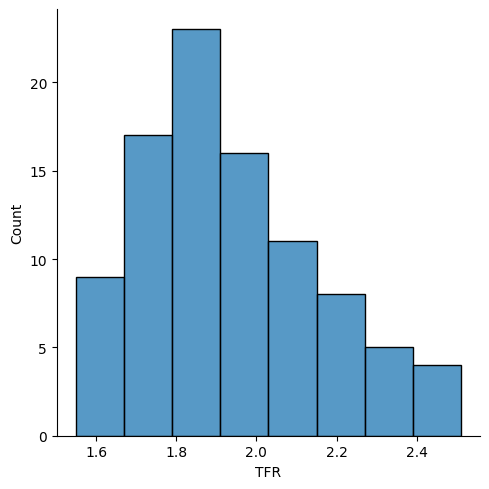

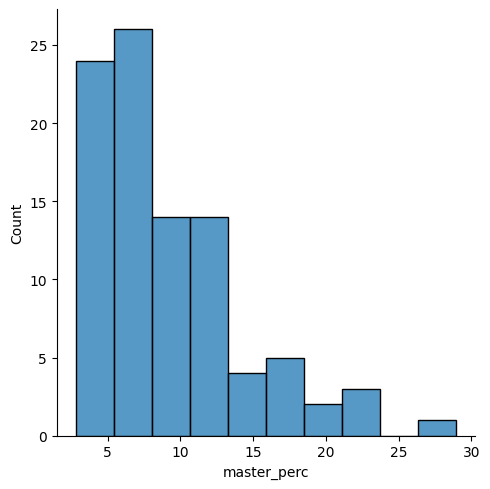

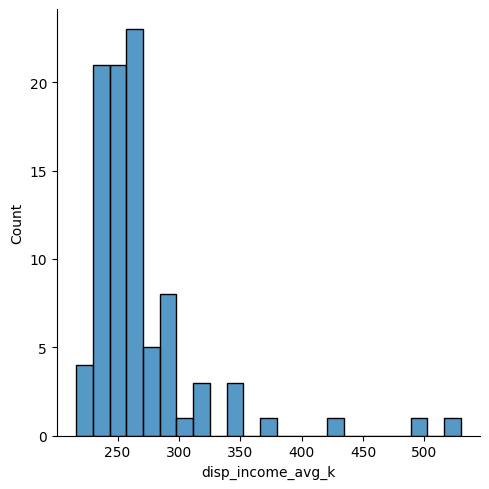

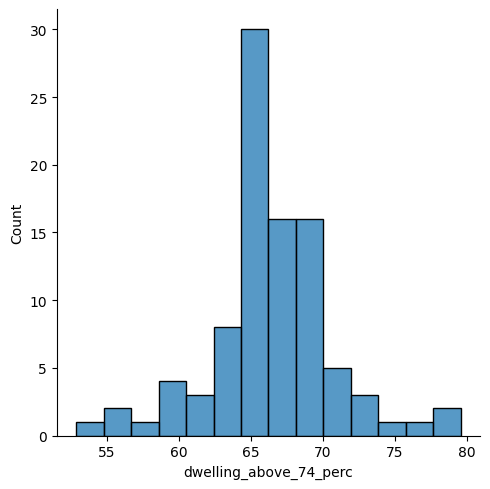

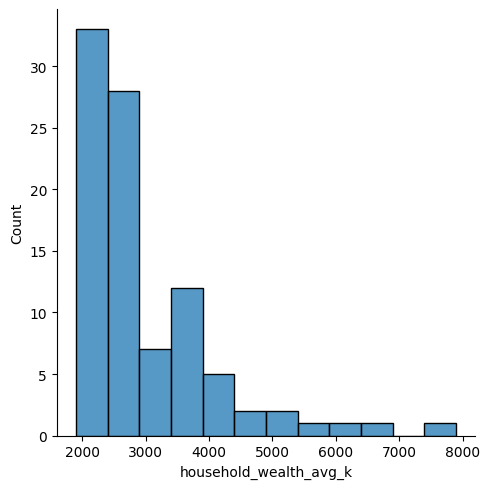

In [335]:
import seaborn as sns

# # Show distributions for categorical variables
for feature in characteristics:
    sns.displot(data, x=feature)

In [337]:
data.columns

Index(['municipality_nm', 'TFR', 'master_perc', 'disp_income_avg_k',
       'dwelling_above_74_perc', 'household_wealth_avg_k', 'kommunekode',
       'municipal_id', 'geometry'],
      dtype='object')

### Multiple regression analysis

1. Check the distribution of the data (if Gaussian -> linear regression; if not gaussian -> generalized linear regression; if not linear -> GAM)

https://analyticsindiamag.com/guide-to-generalized-additive-modelgam-to-improve-simple-linear-regression/

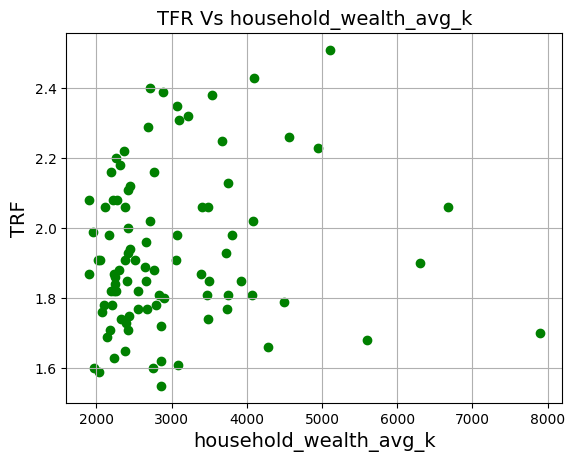

In [340]:
# plot relationship between fertility rate and other variables 
plt.scatter(data['household_wealth_avg_k'], data['TFR'], color='green')
plt.title('TFR Vs household_wealth_avg_k', fontsize=14)
plt.xlabel('household_wealth_avg_k', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

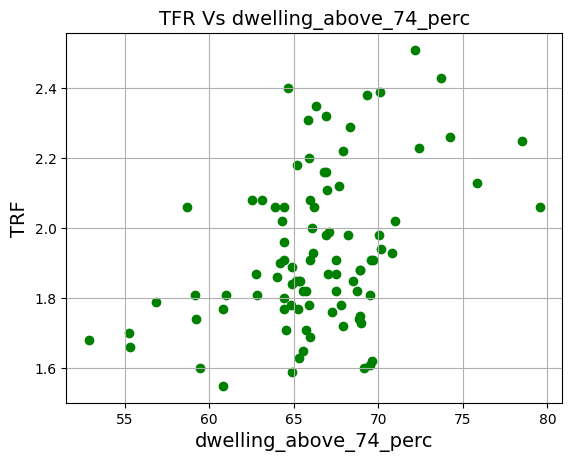

In [339]:
# plot relationship between fertility rate and other variables 
plt.scatter(data['dwelling_above_74_perc'], data['TFR'], color='green')
plt.title('TFR Vs dwelling_above_74_perc', fontsize=14)
plt.xlabel('dwelling_above_74_perc', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

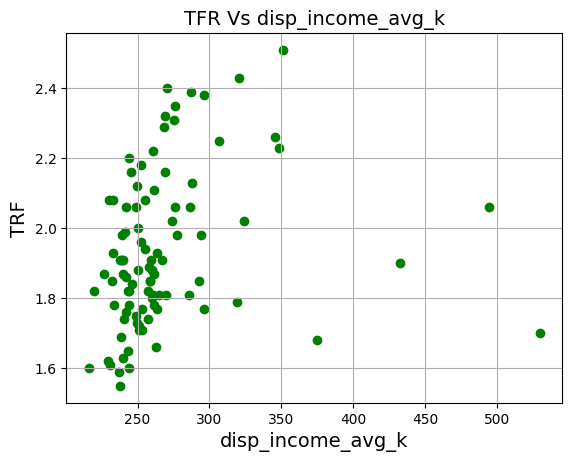

In [338]:
# plot relationship between fertility rate and other variables 
plt.scatter(data['disp_income_avg_k'], data['TFR'], color='green')
plt.title('TFR Vs disp_income_avg_k', fontsize=14)
plt.xlabel('disp_income_avg_k', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

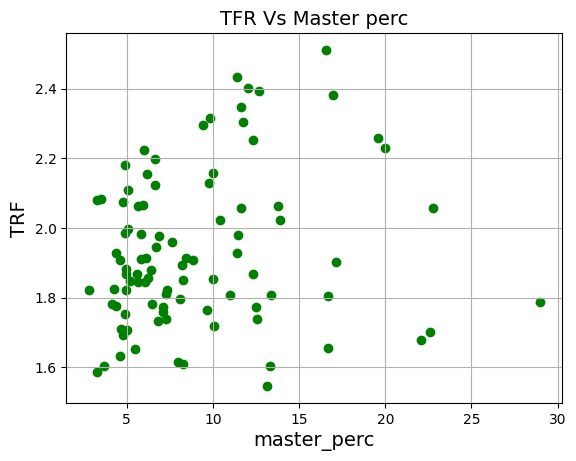

In [ ]:
# plot relationship between fertility rate and other variables 
plt.scatter(data['master_perc'], data['TFR'], color='green')
plt.title('TFR Vs Master perc', fontsize=14)
plt.xlabel('master_perc', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

### Multiple regression analysis

In [342]:
characteristics

['TFR',
 'master_perc',
 'disp_income_avg_k',
 'dwelling_above_74_perc',
 'household_wealth_avg_k']

In [361]:
# Importing the library
import scipy
from scipy import stats
  
# Z-Score using scipy
data['TFR_st'] = stats.zscore(data['TFR'])
data['master_perc_st'] = stats.zscore(data['master_perc'])
data['disp_income_avg_k_st'] = stats.zscore(data['disp_income_avg_k'])
data['dwelling_above_74_perc_st'] = stats.zscore(data['dwelling_above_74_perc'])
data['household_wealth_avg_k_st'] = stats.zscore(data['household_wealth_avg_k'])

In [372]:
from sklearn import linear_model

x = data[['master_perc_st', 'disp_income_avg_k_st', 'dwelling_above_74_perc_st', 'household_wealth_avg_k_st']]
y = data['TFR_st'] 

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)


Intercept: 
 -1.341797982631807e-15
Coefficients: 
 [ 0.51586085  0.82792746  0.48662955 -0.98567817]


In [373]:
import statsmodels.api as sm

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 TFR_st   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     11.86
Date:                Thu, 18 May 2023   Prob (F-statistic):           9.45e-08
Time:                        22:00:47   Log-Likelihood:                -111.91
No. Observations:                  93   AIC:                             233.8
Df Residuals:                      88   BIC:                             246.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### Correlation

In [369]:

data[['TFR', 'master_perc_st', 'disp_income_avg_k_st', 'dwelling_above_74_perc_st', 'household_wealth_avg_k_st']].corr()

,TFR,master_perc_st,disp_income_avg_k_st,dwelling_above_74_perc_st,household_wealth_avg_k_st
TFR,1.000000,0.172037,0.220210,0.411425,0.122774
master_perc_st,0.172037,1.000000,0.768810,-0.263558,0.864469
disp_income_avg_k_st,0.220210,0.768810,1.000000,-0.184811,0.927668
dwelling_above_74_perc_st,0.411425,-0.263558,-0.184811,1.000000,-0.216871
household_wealth_avg_k_st,0.122774,0.864469,0.927668,-0.216871,1.000000
